# Finding cellular regions with superpixel analysis

**Overview:**

Whole-slide images often contain artifacts like marker or acellular regions that
need to be avoided during analysis. In this example we show how HistomicsTK can
be used to develop saliency detection algorithms that segment the slide at low
magnification to generate a map to guide higher magnification analyses. Here we
show how superpixel analysis can be used to locate hypercellular regions that
correspond to tumor-rich content.

This uses Simple Linear Iterative Clustering (SLIC) to get superpixels at a low
slide magnification to detect cellular regions. The first step of this pipeline
detects tissue regions (i.e. individual tissue pieces) using the `get_tissue_mask`
 method of the `histomicstk.saliency` module. Then, each tissue piece is processed
 separately for accuracy and disk space efficiency. It is important to keep in
 mind that this does NOT rely on a tile iterator, but loads the entire tissue
 region (but NOT the whole slide) in memory and passes it on to
 `skimage.segmentation.slic` method. Not using a tile iterator helps keep the
 superpixel sizes large enough to correspond to tissue boundaries.

Once superpixels are segmented, the image is deconvolved and features are extracted from the hematoxylin channel. Features include intensity and possibly also texture features. Then, a mixed component Gaussian mixture model is fit to the features, and median intensity is used to rank superpixel clusters by 'cellularity' (since we are working with the hematoxylin channel).

Note that the decison to fit a gaussian mixture model instead of using K-means clustering is a design choice. If you'd like to experiment, feel free to try other methods of classifying superpixels into clusters using other approaches.

Additional functionality includes contour extraction to get the final segmentation boundaries of cellular regions and to visualize them in HistomicsUI using one's preferred colormap.

**Here are some sample results:**

From left to right: Slide thumbnail, superpixel classifications, contiguous cellular/acellular regions

![cdetection](https://user-images.githubusercontent.com/22067552/65730355-7e92b600-e08f-11e9-918a-507f117f6d77.png)

**Where to look?**

```
|_ histomicstk/
  |_saliency/
     |_cellularity_detection.py 
     |_tests/
        |_test_saliency.py
```

In [1]:
import tempfile
import girder_client
import numpy as np
from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    delete_annotations_in_slide)
from histomicstk.saliency.cellularity_detection_superpixels import (
    Cellularity_detector_superpixels)

import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# color map
vals = np.random.rand(256,3)
vals[0, ...] = [0.9, 0.9, 0.9]
cMap = ListedColormap(1 - vals)

## Prepwork

In [2]:
APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = "5d586d76bd4404c6b1f286ae"
# SAMPLE_SLIDE_ID = "5d8c296cbd4404c6b1fa5572"

gc = girder_client.GirderClient(apiUrl=APIURL)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# This is where the run logs will be saved
logging_savepath = tempfile.mkdtemp()

# color normalization values from TCGA-A2-A3XS-DX1
cnorm_thumbnail = {
    'mu': np.array([9.24496373, -0.00966569,  0.01757247]),
    'sigma': np.array([0.35686209, 0.02566772, 0.02500282]),
}
# from the ROI in Amgad et al, 2019
cnorm_main = {
    'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
    'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),
}

In [3]:
# deleting existing annotations in target slide (if any)
delete_annotations_in_slide(gc, SAMPLE_SLIDE_ID)

## Initialize the cellularity detector

In [4]:
print(Cellularity_detector_superpixels.__init__.__doc__)

Init Cellularity_Detector_Superpixels object.

        Arguments:
        -----------
        gc : object
            girder client object
        slide_id : str
            girder ID of slide
        verbose : int
            0 - Do not print to screen
            1 - Print only key messages
            2 - Print everything to screen
            3 - print everything including from inner functions
        monitorPrefix : str
            text to prepend to printed statements
        logging_savepath : str or None
            where to save run logs
        suppress_warnings : bool
            whether to suppress warnings
        cnorm_params : dict
            Reinhard color normalization parameters. Accepted keys: thumbnail
            and main (since thumbnail normalization is different from color
            normalization of tissue at target magnification. Each entry is a
            dict containing values for mu and sigma. This is either given
            here or can be set using sel

In this example, and as the default behavior, we use a handful of informative intensity features extracted from the hematoxylin channel after color deconvolution to fit a gaussian mixture model. Empirically (on a few test slides), this seems to give better results than using the full suite of intensity and texture features available. Feel free to experiment with this and find the optimum combination of features for your application. 

In [5]:
# init cellularity detector
cds = Cellularity_detector_superpixels(
    gc, slide_id=SAMPLE_SLIDE_ID,
    MAG=3.0, compactness=0.1, spixel_size_baseMag=256 * 256,
    max_cellularity=40,
    visualize_spixels=True, visualize_contiguous=True,
    get_tissue_mask_kwargs={
        'deconvolve_first': False,
        'n_thresholding_steps': 2,
        'sigma': 1.5,
        'min_size': 500, },
    verbose=2, monitorPrefix='test',
    logging_savepath=logging_savepath)

Saving logs to: /tmp/tmpt7dygwhf/2019-09-29_18-04.log


## Set the color normalization values

You can choose to reinhard color normalize the slide thumbnail and/or the tissue image at target magnificaion. You can either provide the mu and sigma values directly or provide the path to an image from which to infer these values. Please refer to the *color_normalization* module for reinhard normalization implementation details. In this example, we use a "high-sensitivity, low-specificity" strategy to detect tissue, followed by the more specific cellularity detection module. In other words, the *tissue_detection* module is used to detect all tissue, and only exclude whitespace and marker. Here we do NOT perform color normalization before tissue detection (empirically gives worse results), but we do normalize when detecting the cellular regions within the tissue. 

In [6]:
# set color normalization for thumbnail
# cds.set_color_normalization_values(
#     mu=cnorm_thumbnail['mu'],
#     sigma=cnorm_thumbnail['sigma'], what='thumbnail')

# set color normalization values for main tissue
cds.set_color_normalization_values(
    mu=cnorm_main['mu'], sigma=cnorm_main['sigma'], what='main')

## Run the detector

In [7]:
print(cds.run.__doc__)

Run cellularity detection and optionally visualize result.

        This runs the cellularity detection +/- visualization pipeline and
        returns a list of CD_single_tissue_piece objects. Each object has
        the following attributes

        tissue_mask : np array
            mask of where tissue is at target magnification
        ymin : int
            min y coordinate at base (scan) magnification
        xmin : int
            min x coordinate at base (scan) magnification
        ymax : int
            max y coordinate at base (scan) magnification
        xmax : int
            max x coordinate at base (scan) magnification
        spixel_mask : np array
            np array where each unique value represents one superpixel
        fdata : pandas DataFrame
            features extracted for each superpixel. Index corresponds to
            values in the spixel_mask. This includes a 'cluster' column
            indicatign which cluster this superpixel belongs to.
        clust

In [8]:
tissue_pieces = cds.run()

test: set_slide_info_and_get_tissue_mask()
test: Tissue piece 1 of 2
test: Tissue piece 1 of 2: set_tissue_rgb()
test: Tissue piece 1 of 2: set_superpixel_mask()
test: Tissue piece 1 of 2: set_superpixel_features()
test: Tissue piece 1 of 2: set_superpixel_assignment()
test: Tissue piece 1 of 2: assign_cellularity_scores()
test: Tissue piece 1 of 2: visualize_individual_superpixels()
test: Tissue piece 1 of 2: Posting doc 1 of 5
test: Tissue piece 1 of 2: Posting doc 2 of 5
test: Tissue piece 1 of 2: Posting doc 3 of 5
test: Tissue piece 1 of 2: Posting doc 4 of 5
test: Tissue piece 1 of 2: Posting doc 5 of 5
test: Tissue piece 1 of 2: visualize_contiguous_superpixels()
test: Tissue piece 1 of 2: Posting doc 1 of 5
test: Tissue piece 1 of 2: Posting doc 2 of 5
test: Tissue piece 1 of 2: Posting doc 3 of 5
test: Tissue piece 1 of 2: Posting doc 4 of 5
test: Tissue piece 1 of 2: Posting doc 5 of 5
test: Tissue piece 2 of 2
test: Tissue piece 2 of 2: set_tissue_rgb()
test: Tissue piece 2 

## Check the results

The resultant list of objects correspond to the results for each "tissue piece" detected in the slide. You may explore various attributes like the offset coordinates, tissue mask, superpixel labeled mask, superpixel feature data, and superpixel cluster properties.

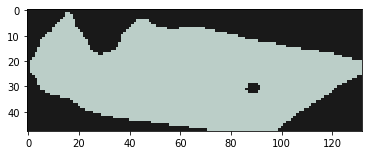

In [9]:
plt.imshow(tissue_pieces[0].tissue_mask, cmap=cMap)

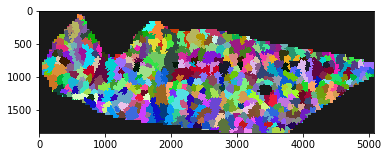

In [10]:
plt.imshow(tissue_pieces[0].spixel_mask, cmap=cMap)

In [11]:
tissue_pieces[0].fdata.head()

,Intensity.Mean,Intensity.Median,Intensity.Std,Intensity.IQR,Intensity.HistEntropy,cluster
5,86.639486,74.0,50.329524,34.0,1.775608,4
6,73.010711,68.0,26.269239,20.0,1.341687,4
67,88.820514,73.0,56.899073,49.0,1.942993,5
68,72.959455,67.0,31.681785,21.0,1.349226,4
71,100.068075,79.0,60.721122,67.0,1.989196,5


In [12]:
tissue_pieces[0].cluster_props

{1: {'cellularity': 20, 'color': 'rgb(253,253,255)'},
 2: {'cellularity': 37, 'color': 'rgb(167,0,0)'},
 3: {'cellularity': 47, 'color': 'rgb(127,0,0)'},
 4: {'cellularity': 26, 'color': 'rgb(255,105,105)'},
 5: {'cellularity': 29, 'color': 'rgb(255,29,29)'}}

## Check the visualization on HistomicsUI

Now you may go to the slide on Digital Slide Archive and check the posted annotations.